<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Energy_Consumption_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction 

## 1.1 Import Libraries

In [5]:
!pip install statsmodels

In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.stattools import kpss, adfuller
from pylab import rcParams
from platform import python_version

print(f'Python Version: {python_version()}')

Python Version: 3.7.12


## 1.2 Configure Settings

In [8]:
rcParams['figure.figsize'] = (10, 6) 
sns.set_theme(palette='muted', style='whitegrid')

## 1.3 Load the ComEd Dataset

In [9]:
path = 'https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/AEP_hourly.csv'
df = pd.read_csv(path)
print(df.shape)
print(df.dtypes)
df.head()

(121273, 2)
Datetime     object
AEP_MW      float64
dtype: object


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# 2. Review Data Contents

Prior to any extensive analysis it's important to examine the initial data. 

In [10]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Columns: 2 entries, Datetime to AEP_MW
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [11]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [12]:
df.isnull().any()

Datetime    False
AEP_MW      False
dtype: bool

To review the `Datetime` column we need to make sure the contents are in the proper datetime format.

In [13]:
df['Datetime'] = df.Datetime.astype('Datetime64')
print(df.dtypes)
df.head()

Datetime    datetime64[ns]
AEP_MW             float64
dtype: object


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [ ]:
df['Datetime'].describe(datetime_is_numeric=True)

count                            66497
mean     2014-10-17 14:11:46.389761792
min                2011-01-01 01:00:00
25%                2012-11-23 21:00:00
50%                2014-10-17 16:00:00
75%                2016-09-09 08:00:00
max                2018-08-03 00:00:00
Name: Datetime, dtype: object

# 3. Time Plot

The starting point for our [EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis) will be the standard time plot. Here the energy observations are plotted against the hourly datetime records. This is to establish that we have our data in the proper format. Here everything looks okay so we will advance to a more thorough analysis. 

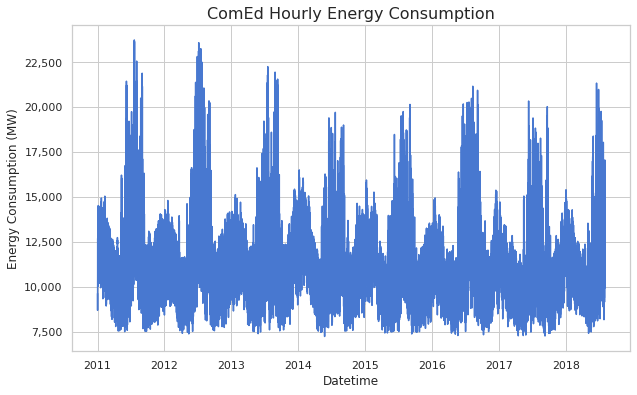

In [ ]:
ax = sns.lineplot(data=df, x='Datetime', y='COMED_MW')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.title('ComEd Hourly Energy Consumption', fontsize=16)
plt.show()

We will add a `QUARTER` column to our timeseries dataframe. This will help with seasonal plotting later on.

In [ ]:
# Get quarters from the datetime
df['QUARTER'] = df['Datetime'].dt.quarter
df.head()

,Datetime,COMED_MW,QUARTER
0,2011-12-31 01:00:00,9970.0,4
1,2011-12-31 02:00:00,9428.0,4
2,2011-12-31 03:00:00,9059.0,4
3,2011-12-31 04:00:00,8817.0,4
4,2011-12-31 05:00:00,8743.0,4


Since we'll be looking at seasonality we can use resampling to convert the timeseries to an average monthly format.  This will also make visual interpretation easier. 

In [ ]:
# Convert dataframe to average monthly format
df = df.resample('M', on='Datetime').mean().rename(columns={'COMED_MW':'MONTHLY_AVG'})
df['QUARTER'] = df['QUARTER'].astype(int)
df.head()

,MONTHLY_AVG,QUARTER
Datetime,,
2011-01-31,12252.029610,1
2011-02-28,11820.212798,1
2011-03-31,11028.816958,1
2011-04-30,10229.681944,2
2011-05-31,10429.517473,2


The result below is a smoother time plot.  More practical when the use case involves monthly billing.

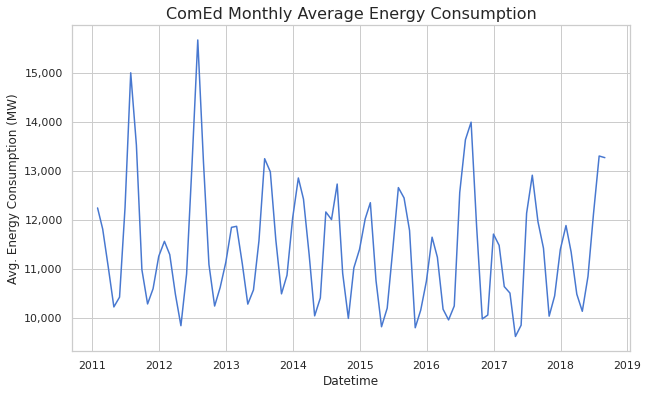

In [ ]:
ax = sns.lineplot(data=df, x='Datetime', y='MONTHLY_AVG')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Datetime')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.title('ComEd Monthly Average Energy Consumption', fontsize=16)
plt.show()

# 4. Lag Plot

A lag plot is used to observe the underlying properties of a timeseries.  It's a type of scatter plot where a set of data from time step `y(t+i)` , with time `t` and lag `i`, is plotted against data from a later time step `y(t)`.  The pattern in a lag plot will show if the timeseries data is random, sinusoidal, autocorrelates, or contains outliers.  These patterns also provide information on suitable models for the data. 

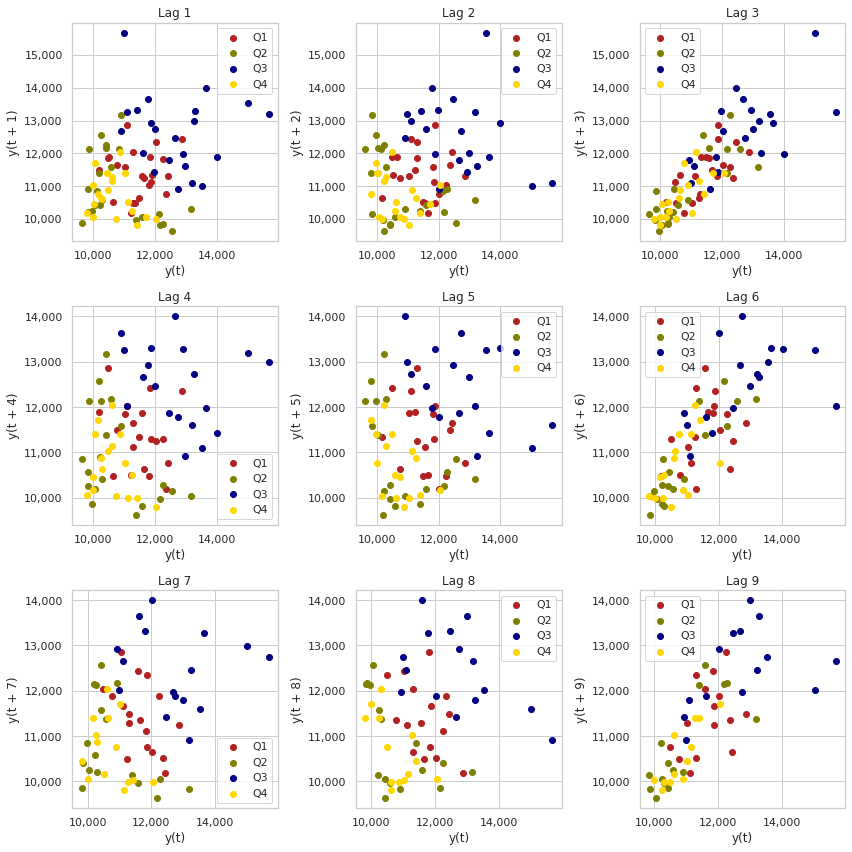

In [ ]:
plt.figure(figsize=(12,12))

for i in range(1, 10):
    ax=plt.subplot(3, 3, i)
    # Create a lag plot for each quarter
    pd.plotting.lag_plot(df.loc[df['QUARTER'] == 1, 'MONTHLY_AVG'], lag=i, c='firebrick', label='Q1')    
    pd.plotting.lag_plot(df.loc[df['QUARTER'] == 2, 'MONTHLY_AVG'], lag=i, c='olive', label='Q2')
    pd.plotting.lag_plot(df.loc[df['QUARTER'] == 3, 'MONTHLY_AVG'], lag=i, c='navy', label='Q3')
    pd.plotting.lag_plot(df.loc[df['QUARTER'] == 4, 'MONTHLY_AVG'], lag=i, c='gold', label='Q4')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend()
    plt.title(f'Lag {i}')

plt.tight_layout()
plt.show()

# 5. Autocorrelation Plot

The autocorrelation plot is similar to the lag plot in that it also checks for randomness in the timeseries. Autocorrelations are calculated for the data at different lags. A completely random timeseries will show autocorrelations near zero for all lags. 

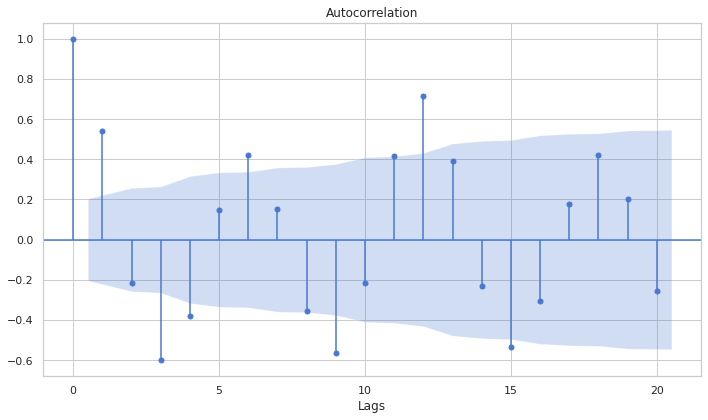

In [ ]:
# Select a multiple of the seasonal frequency for the number of lags
plot_acf(df['MONTHLY_AVG'])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

Partial autocorrelation is also a calculation for data at different lags, but with indirect correlations removed. This plot can be used to specify a regression model for the timeseries. The first autocorrelations are typically the most significant for analysis. 

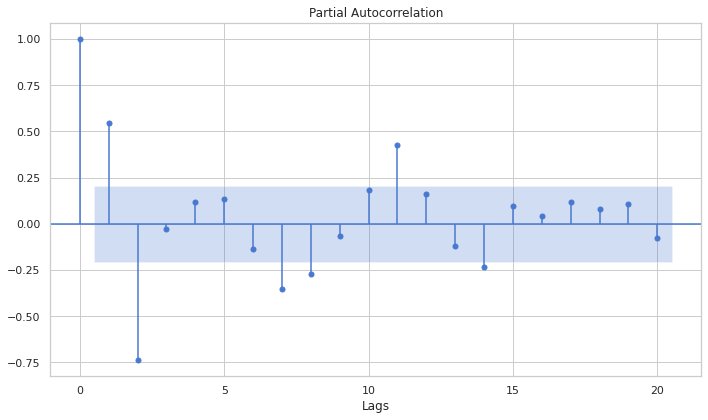

In [ ]:
plot_pacf(df['MONTHLY_AVG'])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

# 7. Timeseries Differencing

In [ ]:
diff = df['MONTHLY_AVG'].diff(1).dropna()
diff.head()

Datetime
2011-02-28    -431.816812
2011-03-31    -791.395839
2011-04-30    -799.135014
2011-05-31     199.835529
2011-06-30    1831.760305
Freq: M, Name: MONTHLY_AVG, dtype: float64

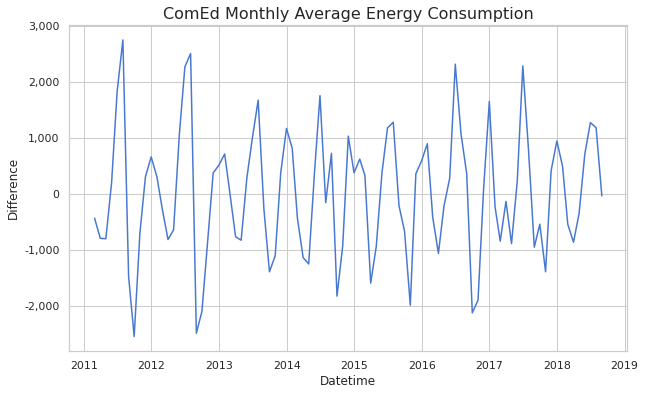

In [ ]:
ax = sns.lineplot(data=diff)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Datetime')
plt.ylabel('Difference')
plt.title('ComEd Monthly Average Energy Consumption', fontsize=16)
plt.show()

As shown above the differenced data is more stable about the mean.  To confirm stationarity we'll utilize the following two tests.

## 7.1 Kwiatkowski-Phillips-Schmidt-Shin Test

In [ ]:
def kpss_test(timeseries):
    # Create a metrics table for kpss test
    print('KPSS Metrics:')    
    kpsstest = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(
        kpsstest[0:3], 
        index = ['Test Statistic', 
               'p-Value', 
               'Number of Lags'
        ]
    )
    
    for key, value in kpsstest[3].items():
        kpss_output[f'Critical Value ({key})'] = value
    
    return kpss_output

In [ ]:
kpss_test(diff)

KPSS Metrics:


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Test Statistic           0.117897
p-Value                  0.100000
Number of Lags           5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

The large p-value is above 0.05, which means our differenced data is trend-stationary. The null hypothesis is accepted.

## 7.2 Augmented Dickey-Fuller Test

The second of our stationarity tests is the Augmented Dickey-Fuller ([ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)) Test.  This test assumes the data is non-stationary as the null hypothesis. A p-value below 0.05 indicates a stationary timeseries. This is opposite the KPSS test so care must be taken when making conclusions.     

In [ ]:
def adf_test(timeseries):
    # Create a metrics table for adf test
    print('Dickey-Fuller Metrics:')    
    adftest = adfuller(timeseries, autolag='AIC')
    adfoutput = pd.Series(
        adftest[0:4],
        index = [
            'Test Statistic',
            'p-Value',
            'Number of Lags',
            'Number of Observations'
        ]
    )
    
    for key, value in adftest[4].items():
        adfoutput[f'Critical Value ({key})'] = value
    
    return adfoutput

In [ ]:
adf_test(diff)

Dickey-Fuller Metrics:


Test Statistic           -7.708800e+00
p-Value                   1.280200e-11
Number of Lags            1.000000e+01
Number of Observations    8.000000e+01
Critical Value (1%)      -3.514869e+00
Critical Value (5%)      -2.898409e+00
Critical Value (10%)     -2.586439e+00
dtype: float64

# 8. Seasonal Plots

## 8.1 Quarter Plot

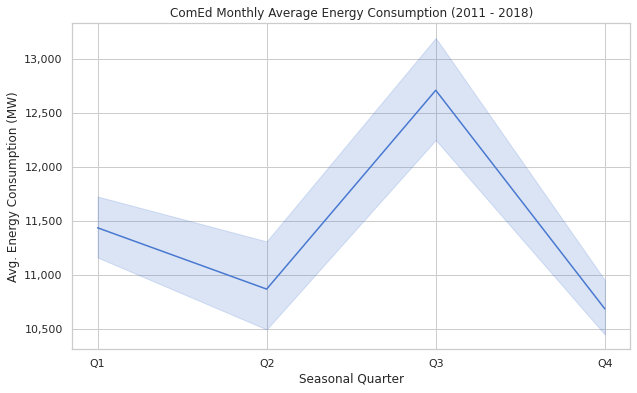

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(ax=ax, data=df, x='QUARTER', y='MONTHLY_AVG', ci=95)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
ax.set_ylabel('Avg. Energy Consumption (MW)')
ax.set_xlabel('Seasonal Quarter')
ax.set_title('ComEd Monthly Average Energy Consumption (2011 - 2018)')
plt.show()

It looks like the third quarter sees the most monthly average energy usage each year.  We can further investigate this quarterly pattern by plotting the data against each month.

## 8.2 Month Plot

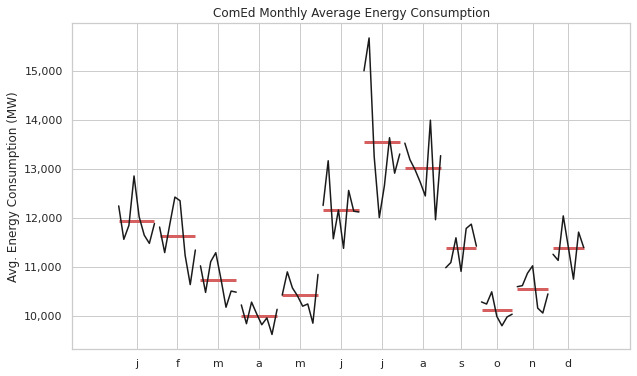

In [ ]:
fig, ax = plt.subplots()
month_plot(df['MONTHLY_AVG'], ax=ax)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('ComEd Monthly Average Energy Consumption')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.show()

We can see that July is the month where peak average energy usage occurs.  January sees the highest usage out of the winter months, and the lowest points are in April and October. Overall, this is a close reflection of the pattern observed in the quarter plot. 

# 9. Seasonal Moving Average

A moving average is created by calculating the mean of timeseries values over a specified set of past timesteps.  This has the effect of smoothing out the time plot.  We'll plot a 3 month moving average that corresponds to each seasonal quarter.  

In [ ]:
# Create a 3 month moving average
df['MOVING_AVG'] = df['MONTHLY_AVG'].rolling(3, min_periods=3).mean()
df.head(12)

,MONTHLY_AVG,QUARTER,MOVING_AVG
Datetime,,,
2011-01-31,12252.029610,1,NaN
2011-02-28,11820.212798,1,NaN
2011-03-31,11028.816958,1,11700.353122
2011-04-30,10229.681944,2,11026.237233
2011-05-31,10429.517473,2,10562.672125
2011-06-30,12261.277778,2,10973.492398
2011-07-31,15012.403226,3,12567.732826
2011-08-31,13534.995968,3,13602.892324
2011-09-30,10989.898611,3,13179.099268


In the `MOVING_AVG` column you can observe the consecutive means for each of the previous three monthly averages. This is called a moving average of the third order. The higher the order, the smoother the plot.

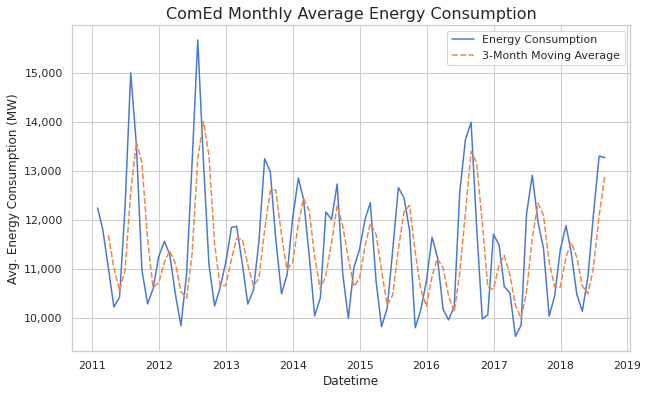

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=df[['MONTHLY_AVG', 'MOVING_AVG']])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Datetime')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.legend(labels=['Energy Consumption', '3-Month Moving Average'])
plt.title('ComEd Monthly Average Energy Consumption', fontsize=16)
plt.show()

A plot of the 3-month moving average shows a smoother timeseries with less fluctuations. This is a method typically used to estimate the trend of a dataset when performing decomposition. 

# 10. Seasonal Trend Decomposition using Loess

Timeseries [decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series) is a process that extracts the features for analysis.  Seasonal Trend Decomposition using Loess (STL) is a specific type of decomposition that can estimate non-linear relationships. This method is robust to outliers and can handle any kind of seasonality within the data. The function will return three components of the timeseries:
* Season
* Trend
* Residual

A residual or remainder component is what is left over after extracting the season and the trend. A residual that shows strong elements of the trend or season reflects an incomplete decomposition. Residual points that deviate significantly can be classified as outliers.    

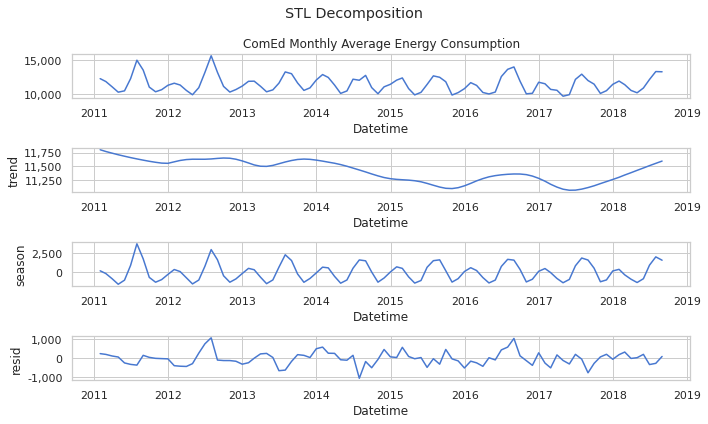

In [ ]:
# Decompose the timeseries data
res = STL(df['MONTHLY_AVG'], period=12).fit()

# Create plots for each STL component
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

plt.suptitle('STL Decomposition')

sns.lineplot(data=df['MONTHLY_AVG'], ax=ax1)
ax1.set_title('ComEd Monthly Average Energy Consumption')
ax1.set_ylabel('')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

sns.lineplot(data=res.trend, ax=ax2)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

sns.lineplot(data=res.seasonal, ax=ax3)
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

sns.lineplot(data=res.resid, ax=ax4)
ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

Here we see a seasonal component similar in pattern to our quarter and month plots. The smoothed trend displays a gradual drop in average energy usage from 2011 to 2016. The residual component is random and doesn't show significant signal from the trend or season.   

# 11. Conclusion

We've employed various timeseries visualizations for analysis of our ComEd energy use case.  Beginning with a standard time plot, we worked through lag plots and autocorrelations to differencing, seasonal plots, a moving average, and STL decomposition.  The next phase in this timeseries exercise will be to explore forecasting methods.   